In [7]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


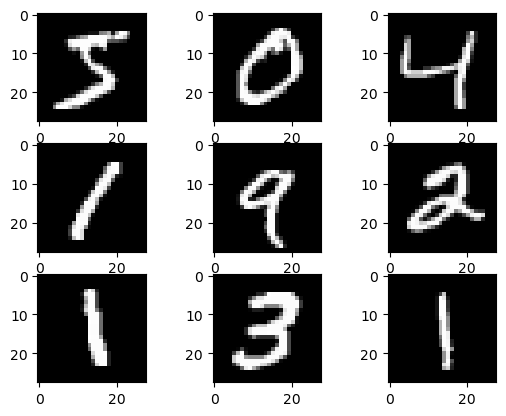

In [8]:
(trainX, trainy), (testX, testy) = mnist.load_data()
# Посмотрим, что там
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# Выведем первые несколько изображений
for i in range(9):
    plt.subplot(330 + 1 + i)
    # Покажем пиксети как есть
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

plt.show()

In [9]:
# Загрузка набора данных
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # Меняем форму, чтобы набор был одноканальным
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # применяем унитарное кодирование к размеченным выходам
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [10]:
# Масштабирование
def prep_pixels(train, test):
    # Конвертируем в вещественные значения
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Приводим яркости к диапазону [0; 1]
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

In [11]:
# Построение модели CNN
def define_model(): 
    model = Sequential() 
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))) 
    model.add(BatchNormalization())  # 
    model.add(MaxPooling2D((2, 2))) 
    model.add(Flatten()) 
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform')) 
    model.add(Dense(10, activation='softmax')) 
    # compile model 
    opt = SGD(learning_rate=0.01, momentum=0.9) 
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    return model

In [12]:
model = define_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)               

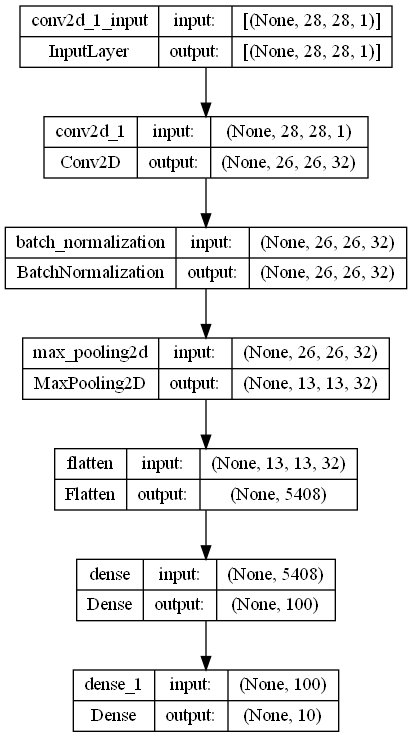

In [13]:
#визуализация модели
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# Построим и оценим модель, используя k-fold кросс-валидацию
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # Настраиваем кросс-валидацию
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # Обходим все разбиения
    for train_ix, test_ix in kfold.split(dataX):
        # Строим модель
        model = define_model()
        # Получаем данные для обучающей и проверочной выборки
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # Учим модель - это не очень быстро на старых ПК, но за несколько минут отработает
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # Оцениваем модель
        _, acc = model.evaluate(testX, testY, verbose=1)
        print('> %.3f' % (acc * 100.0))
        # Сохраняем статистику - пригодится для построения графиков
        scores.append(acc)
        histories.append(history)
        
    return scores, histories

In [15]:
# Строим кривые обучения для диагностики
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [16]:
# Подбиваем итоги по результатам
def summarize_performance(scores):
    # Выводим статистику
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # Строим графики (коробочный график и "усы")
    plt.boxplot(scores)
    plt.show()

375/375 [==============================] - 2s 6ms/step - loss: 0.0759 - accuracy: 0.9858
> 98.575
375/375 [==============================] - 2s 6ms/step - loss: 0.0731 - accuracy: 0.9874
> 98.742
375/375 [==============================] - 2s 6ms/step - loss: 0.0739 - accuracy: 0.9869
> 98.692
375/375 [==============================] - 2s 6ms/step - loss: 0.0558 - accuracy: 0.9885
> 98.850
375/375 [==============================] - 2s 6ms/step - loss: 0.0677 - accuracy: 0.9878
> 98.783


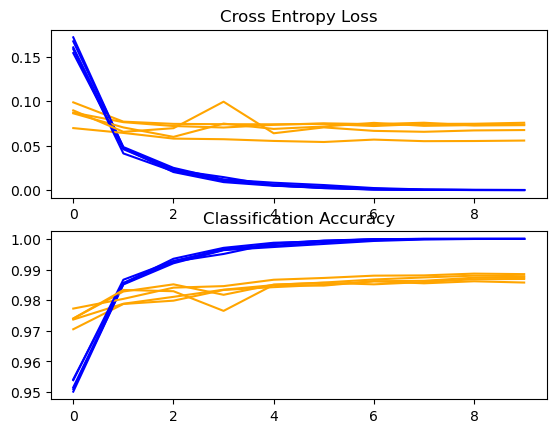

Accuracy: mean=98.728 std=0.093, n=5


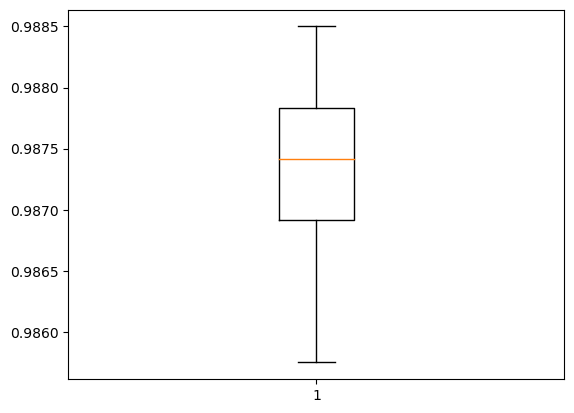

In [17]:
# Запускаем процесс - это главная функция
def run():
    # Грузим данные
    trainX, trainY, testX, testY = load_dataset()
    # Нормализуем изображения для Tensorflow и нейросети
    trainX, testX = prep_pixels(trainX, testX)
    # Строим и оцениваем модель
    scores, histories = evaluate_model(trainX, trainY)
    # Строим кривые обучения
    summarize_diagnostics(histories)
    # Считаем агрегированную статистику
    summarize_performance(scores)
 

# Точка входа - 3... 2... 1... Поехали!
run()

In [ ]:
#После добавления слоя BatchNormalization вы можете оценить изменение производительности модели